In [ ]:
!pip install -r analyser/requirements.txt

In [1]:
import pandas

In [2]:
df = pandas.read_csv("monitor/data/punching.tsv", names= [
    "right bicep",
    "right tricep",
    "left bicep",
    "left tricep",
    "right thigh",
    "right hamstring",
    "left thigh",
    "left hamstring"
], sep="\t")

In [3]:
df.head()

,right bicep,right tricep,left bicep,left tricep,right thigh,right hamstring,left thigh,left hamstring
0,139,-310,-4000,-114,1824,-1171,-4000,1533
1,798,-203,-4000,-318,3013,-1010,-4000,1597
2,1616,-78,-4000,-514,2813,-945,-4000,1598
3,1832,-66,-3935,-695,253,-912,-4000,1598
4,3514,-116,-2737,-724,-215,-875,-4000,1598


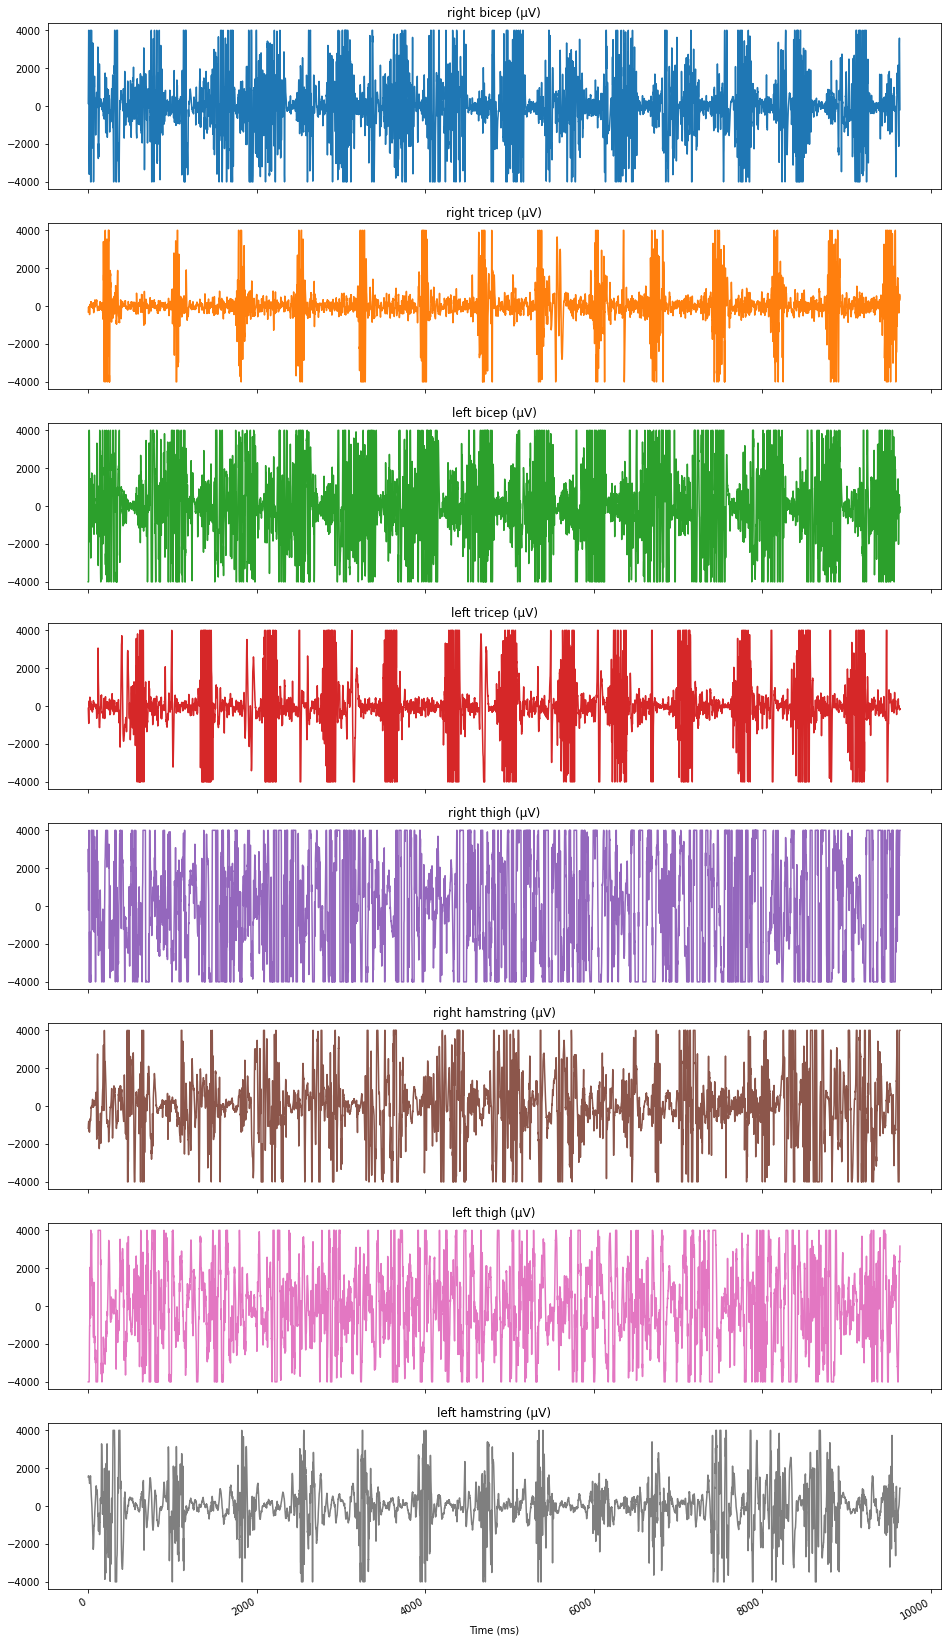

In [4]:
df.index.name = "Time (ms)"
titles = [f"{col} (µV)" for col in df.columns]
df.plot(subplots=True, sharex=True, title=titles, legend=False, layout=(8, 1), figsize=(16,32));

In [5]:
from skmultiflow.drift_detection import ADWIN

all_drifts = {}
for column in df.columns:
    delta = 1.0
    detector = ADWIN(delta)
    drifts = []
    last_rate = 0
    drift_rate_up = 0.1
    drift_rate_down = 0.0001
    for potential in df[column].values:
        detector.add_element(potential)
        if detector.detected_change():
            drifts.append(potential)
        else:
            drifts.append(None)
        if ((drift_rate_up * detector.width) > 0):
            drift_rate = detector.n_detections / detector.width
            if (last_rate <= drift_rate) and (drift_rate >= drift_rate_up):
                delta = detector.delta / 10
                if delta >= drift_rate_down:
                    detector.delta = delta
                    last_rate = drift_rate
            elif (last_rate >= drift_rate) and (drift_rate <= drift_rate_down):
                delta = detector.delta * 10
                if delta <= drift_rate_up:
                    detector.delta = delta
                    last_rate = drift_rate
    print(f"delta: {detector.delta}, drift rate: {drift_rate}")
    all_drifts[column] = drifts
    detector.reset()

delta: 1.0, drift rate: 0.0009033423667570009
delta: 0.1, drift rate: 0.0011066027296200663
delta: 0.1, drift rate: 0.0012307692307692308
delta: 0.001, drift rate: 0.001200742277043991
delta: 0.001, drift rate: 0.005675100496571293
delta: 0.001, drift rate: 0.003687172520861634
delta: 0.001, drift rate: 0.007170661749641467
delta: 0.001, drift rate: 0.00297574765659872


In [6]:
for column in all_drifts:
    print(column, sum([1 for el in all_drifts[column] if el is not None]), len(all_drifts[column]))

right bicep 7 9637
right tricep 9 9637
left bicep 10 9637
left tricep 11 9637
right thigh 24 9637
right hamstring 19 9637
left thigh 35 9637
left hamstring 20 9637


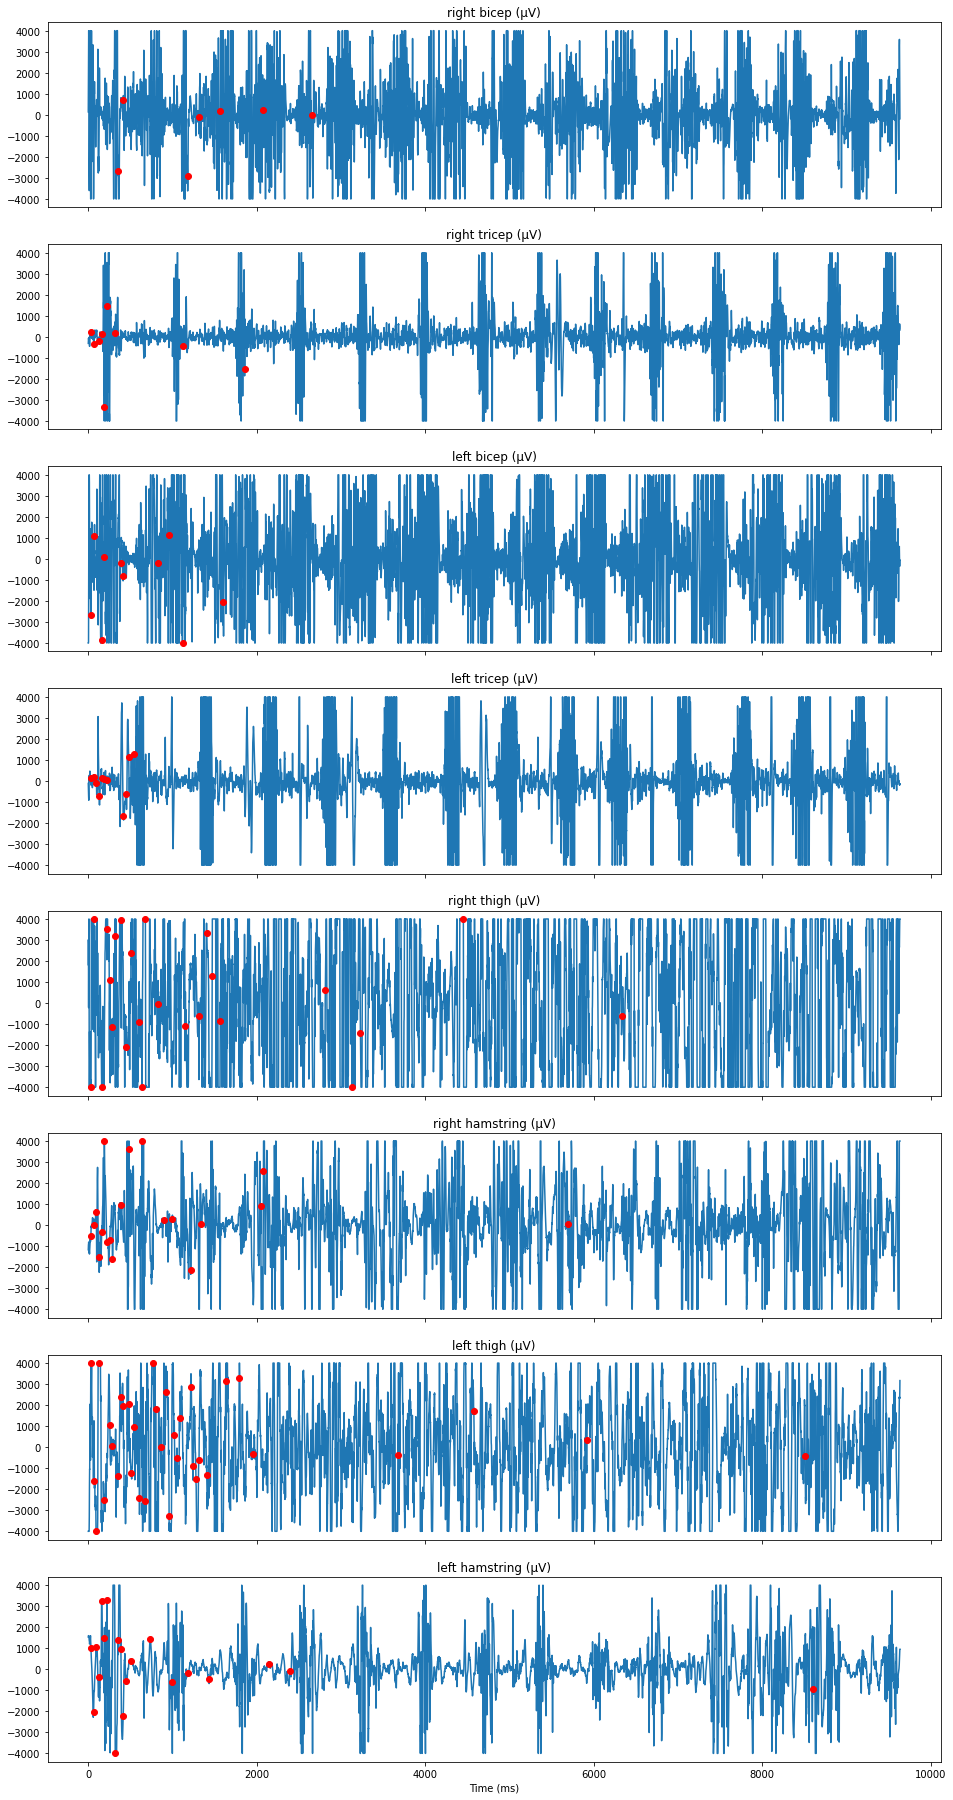

In [7]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(8, 1, figsize=(16, 32), sharex=True);

for ax, column in enumerate(df.columns):
    drift = all_drifts[column]
    df[column].plot(ax=axes[ax], title=titles[ax])
    axes[ax].plot(range(len(drift)), drift, "ro")